In [1]:
%matplotlib inline


# Spectral Parameterization
## 00: Model Description


A description of and introduction to the power spectrum model.


Introduction
------------

Welcome to the tutorials!

In this first tutorial, we will introduce an overview and description of power spectrum
model, as well as visualizing some examples.

Keep in mind as you go, that if you want more information that describes, motivates, and
justifies our modeling approach, you can also check out the associated
[paper](https://www.nature.com/articles/s41593-020-00744-x),
and/or the
[motivations](https://fooof-tools.github.io/fooof/auto_tutorials/index.html)
section of the site.




**Example Power Spectra and Models**

First, we will import and run some code to simulate some example power spectra, and
fit some power spectrum models to them, to use as examples.

For the purpose of this tutorial, you don't need to know how this code works
yet, and can skip past reading the code itself.




In [2]:
# Install necessary packages (for Colab)
!pip install fooof

In [3]:
# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectrum
from fooof.plts.annotate import plot_annotated_model

In [4]:
# Set random seed, for consistency generating simulated data
set_random_seed(21)

# Simulate example power spectra
freqs1, powers1 = gen_power_spectrum([3, 40], [1, 1],
                                     [[10, 0.2, 1.25], [30, 0.15, 2]])
freqs2, powers2 = gen_power_spectrum([1, 150], [1, 125, 1.25],
                                     [[8, 0.15, 1.], [30, 0.1, 2]])

In [5]:
# Initialize power spectrum model objects and fit the power spectra
fm1 = FOOOF(min_peak_height=0.05, verbose=False)
fm2 = FOOOF(min_peak_height=0.05, aperiodic_mode='knee', verbose=False)
fm1.fit(freqs1, powers1)
fm2.fit(freqs2, powers2)

Now, we have some data and models to work with.

To start with, we can plot one of our simulated power spectra.

Plotted below is an example power spectrum, plotted in semi-log space (log10 power values
and linear frequencies). This is our data, that we will be trying to model.

In the plot, we see a power spectrum in which there is decreasing power across increasing
frequencies. In some frequency regions, there is a 'peak' of power, over and above the general
trend across frequencies. These properties - a pattern of decreasing power across frequencies,
with overlying peaks - are considered to be hallmarks of neural field data.




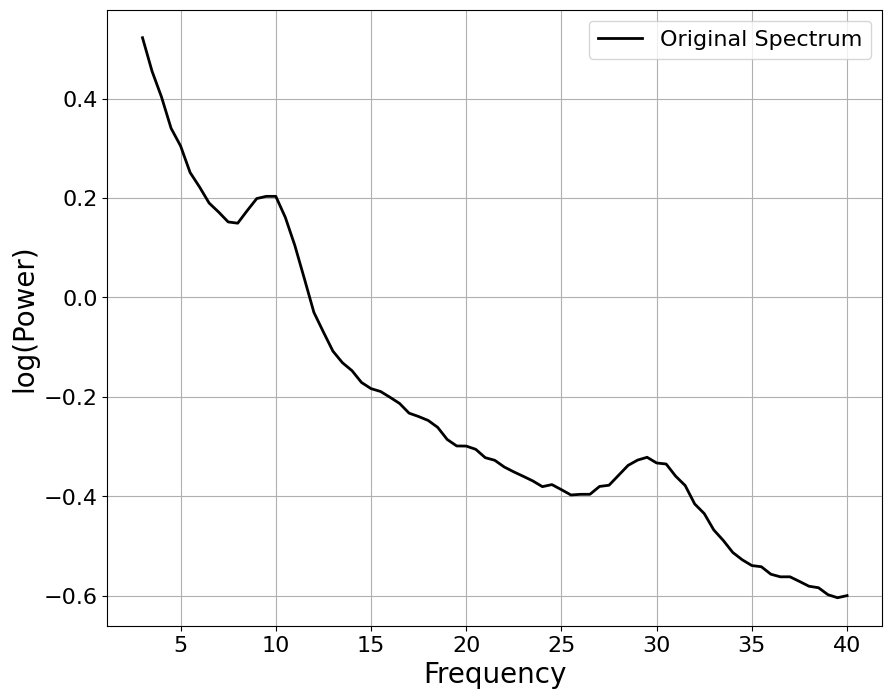

In [6]:
# Plot one of the example power spectra
plot_spectrum(freqs1, powers1, log_powers=True,
              color='black', label='Original Spectrum')

Conceptual Overview
-------------------

The goal of this module is to fit models to parameterize neural power spectra.

One reason to do so is the idea that there are multiple distinct 'components' within
neural field data. The model is therefore designed to measure these different
'components' of the data.

By components, we mean that we are going to conceptualize neural field data as consisting
of a combination of periodic (oscillatory) and aperiodic activity. Restated, we could say
that neural data contains both periodic and aperiodic components.

The goal of the model is to measure these components, separately and explicitly,
from frequency representations of neural field data (neural power spectra).




**Visualizing Power Spectrum Models**

First, let's start by revisiting the example power spectrum, this time also adding the model
fit to the plot.

In the plot below, black is the data, same as before, and in red we've added the
model fit of the data. If things are working, this line should be good approximation
of the data.




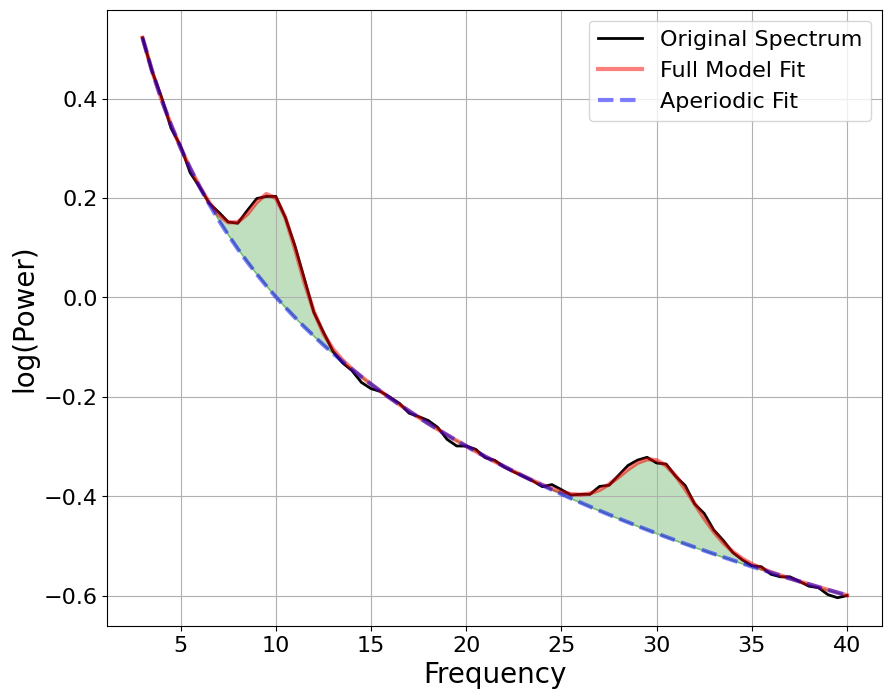

In [7]:
# Plot an example power spectrum, with a model fit
fm1.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'})

Given the full model, in red, we can then describe this spectrum in terms of the
'components' that make up the model fit, which are:

- `aperiodic`: activity with no characteristic frequency (or 'non-frequency specific' activity)

  - in power spectra, this looks like a trend across all frequencies
  - in the plot above, this is what is captured by the dashed blue line
- `periodic` : activity with a characteristic frequency

  - in power spectra, this looks like a 'peak', or 'bump', reflecting frequency specific power
  - in the plot above, this is what is captured by the green shaded peaks

Each of these components also has different 'features' or 'properties', that we want to
describe and measure. Since these 'features' are things that we will be fitting in
the model, we will call them `parameters` (as in, the 'model parameters').

The full model of the power spectrum is the combination of the two components:
the aperiodic component and the periodic component (the set of peaks).

The goal of the model is to measure these two components, to create the full model
fit, in a way that accurately and quantitatively describes the data.




**Mathematical Description of Overall Model**

To enact the conceptual idea described above, we will need to formalize the model. To do
so, throughout the rest of this tutorial, we will lay out the mathematical description of
how neural power spectra can be modeled as a combination of periodic and aperiodic activity.

Overall, the goal is to describe a neural power spectrum, described as $NPS$, as
a combination of periodic and aperiodic components. We will describe each of these
components in their own section.

Note that as we go, we will continue to consider power in log10 spacing. You will
also see each component includes $(F)$, where $F$ is the array of
frequency values (in linear spacing) for the power spectrum, which just indicates that
each component is a function of frequency.




Periodic Component
------------------

By periodic activity, we mean activity that has a characteristic frequency.
This includes what are typically referred to as neural oscillations, often described
in particular frequency bands such as delta, theta, alpha, beta, gamma, etc.

In the frequency domain, putative oscillations are frequency regions in which
there are 'bumps' of power over and above the aperiodic component.
We will generally refer to the these as 'peaks' in the neural power spectrum.

To measure the periodic activity, we would like to describe these peaks, without our
measures of these peaks being influenced by co-occurring aperiodic activity.
This is important, since, as we can see in the plots above, the aperiodic and periodic
components of the data can 'overlap', in frequency space. This means the total power
at a given frequency may have contributions from both components. To measure periodic power,
specifically, we need to measure the power relative to the aperiodic component of the data.

Next, let's explore an annotated version of our power spectrum model.




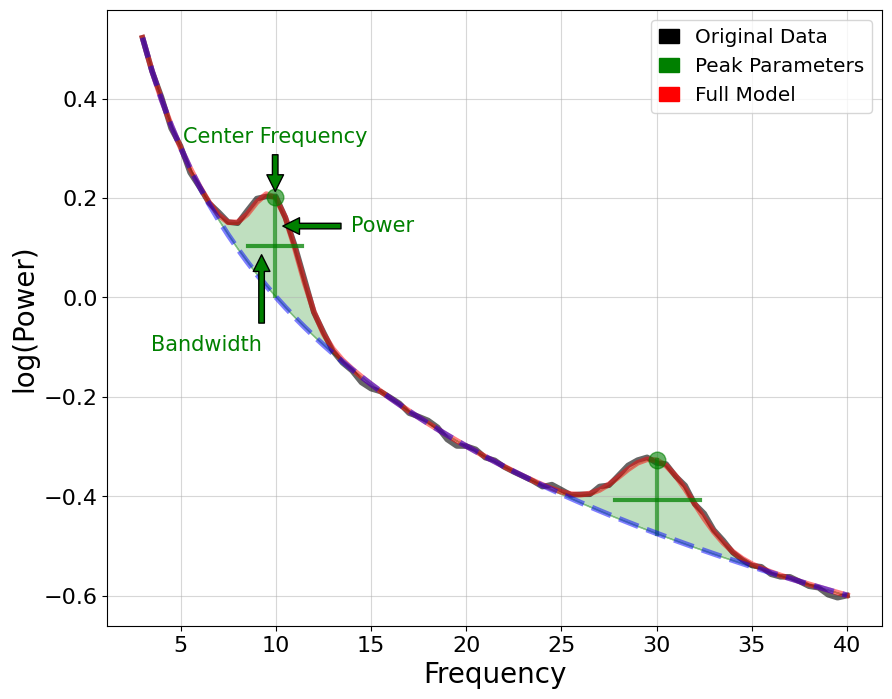

In [8]:
# Plot an annotated version of the power spectrum model
plot_annotated_model(fm1, annotate_aperiodic=False)

In the labeled plot above, we can again see the different components of the model,
as well as the labeled peak parameters.

Note that vertical labels reflect parameters measured in the x-axis units, so in frequency,
where as horizontal labels reflect parameters measured in y-axis units, so power.

The periodic parameters are:

- the `center frequency` of the peak, in units of frequency
- the `power` of the peak, over the aperiodic component, in units of power
- the `bandwidth`, or the width of the peak, in units of frequency

Wherever we detect a peak, these are the parameters that we will fit to the peak,
to describe this component of the data.




**Mathematical Description of the Periodic Component**

To fit this periodic activity - the regions of power over above the aperiodic component,
or 'peaks' - the model uses Gaussians. As we've seen, there can be multiple peaks in the model.

Each Gaussian, $n$, referred to as $G(F)_n$, is of the form:

\begin{align}G(F)_n = a * exp (\frac{- (F - c)^2}{2 * w^2})\end{align}

This describes each peak in terms of parameters `a`, `c` and `w`, where:

- $a$ is the height of the peak, over and above the aperiodic component
- $c$ is the center frequency of the peak
- $w$ is the width of the peak
- $F$ is the array of frequency values




Aperiodic Component
-------------------

By 'aperiodic' activity, we mean activity that is not rhythmic, or activity that has
no characteristic frequency.

In the power spectrum, we typically see this as 1/f-like activity, whereby (in linear space)
the power across frequencies decreases with a $\frac{1}{F^\chi}$ relationship.

To measure the aperiodic activity, we would like to describe the pattern of activity
across all frequencies, without our measure being influenced by co-occurring periodic
activity (peaks).




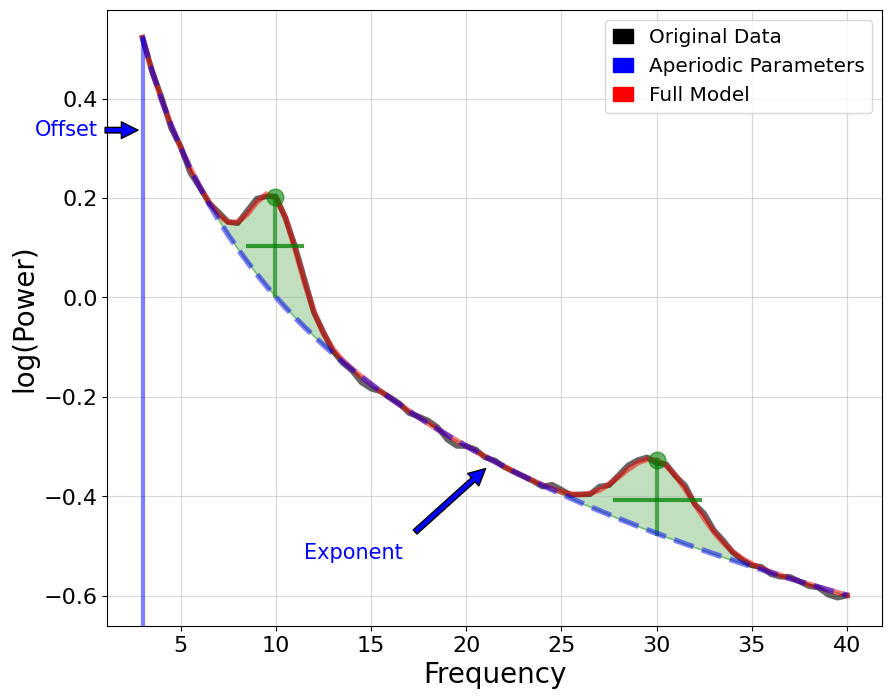

In [9]:
# Plot an annotated version of the power spectrum model
plot_annotated_model(fm1, annotate_peaks=False)

The aperiodic parameters in the above plot are:

- the `offset`, or overall up/down translation of the whole spectrum
- the `exponent`, which describes the 'curve', or overall 'line' of the aperiodic component

Note that diagonal labels indicate unit-less measures (in neither units of frequency or power).




**Mathematical Description of the Aperiodic Component**

To fit the aperiodic component, we will use the function $L$:

\begin{align}L(F) = b - \log(k + F^\chi)\end{align}

Note that this function is fit on the semi-log power spectrum, meaning linear frequencies
and $log_{10}$ power values.

In this formulation, the parameters $b$, $k$, and $\chi$
define the aperiodic component, as:

- $b$ is the broadband 'offset'
- $k$ is the 'knee'
- $\chi$ is the 'exponent' of the aperiodic fit
- $F$ is the array of frequency values

Note that fitting the knee parameter is optional. If used, the knee parameter defines a
'bend' in the aperiodic `1/f` like component of the data. If not used, the 'knee'
parameter is set to zero.

This function form is technically described as a Lorentzian function. We use the option
of adding a knee parameter, since even though neural data is often discussed in terms
of having `1/f` activity, there is often not a single `1/f` characteristic, especially
across broader frequency ranges. Therefore, using this function form allows for modeling
bends in the power spectrum of the aperiodic component, if and when they occur.

Note that if we were to want the equivalent function in linear power, using $AP$
to indicate the aperiodic component in linear spacing, it would be:

\begin{align}AP(F) = 10^b * \frac{1}{(k + F^\chi)}\end{align}




**A Note on Logging**

So far, we have been plotting in semi-log, meaning the x-axis (frequency) is in linear
spacing, and the y-axis (power) is in log10 space. This is common practice, as power values
are exponentially distributed.

It can also be useful, for visualization, to plot with both axes on a log scale.
Note that in this module, plotting in log-log is just a visualization choice, and does
not affect how the data is stored and/or how models are fit.

Below we can see the same spectrum again, with all the annotations on, plotted in log-log.
The most notable difference is that the aperiodic component is a straight line in log-log
spacing. This is a hallmark of `1/f` activity.




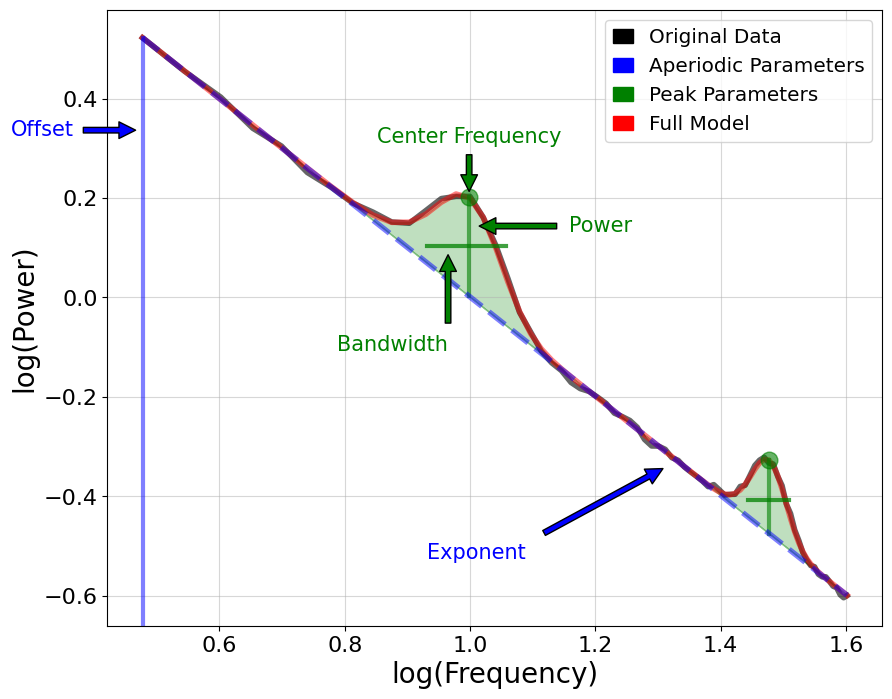

In [10]:
# Plot the power spectrum model, in log-log space
plot_annotated_model(fm1, plt_log=True)

**Relating Exponents to Power Spectrum Slope**

Another way to measure 1/f properties in neural power spectra is to measure the slope
of the spectrum in log-log spacing, fitting a linear equation as:

\begin{align}L(log(F)) = aF + b\end{align}

Where:

- $a$ is the power spectrum slope
- $b$ is the offset
- $F$ is the array of frequency values

In this formulation, the data is considered in log-log space, meaning the frequency values
are also in log space. Since 1/f is a straight line in log-log spacing, this approach captures
1/f activity.

This is equivalent to the power spectrum model in this module, when fitting with no knee,
with a direct relationship between the slope ($a$) and the exponent ($\chi$):

\begin{align}\chi = -a\end{align}




**Fitting Knees**

In the original model we fit and explored, there was no aperiodic 'knee'. Depending on
the data, or the frequency range, there may or may not be a knee present in the data
(more on that later in the tutorial).

In the next plot, there is another annotated model, from a broader frequency range that also
includes a knee. When plotted in log-log, the presence of a knee can be seen as 'bend' or
'knee' in the  aperiodic component.




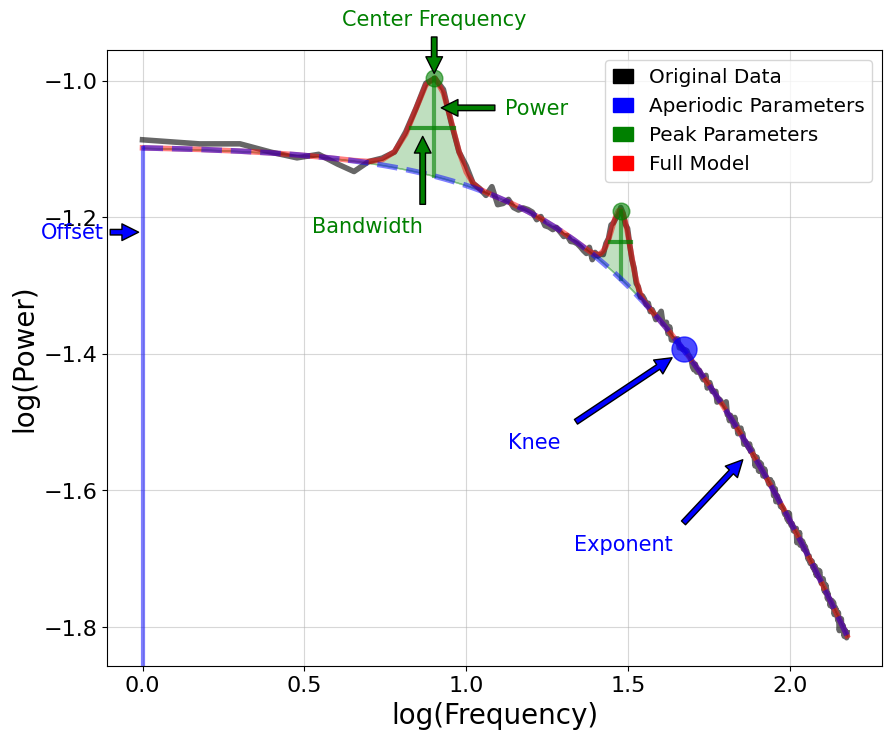

In [11]:
# Plot an annotated version of the power spectrum model
plot_annotated_model(fm2, plt_log=True)

The knee parameter fit to the model is a unit-less value that describes the curve of the
aperiodic component (when plotted in log-log spacing). On the plot above, the annotation
references the knee as the dot on the plot at the bend point.




Conclusion
----------

So far, we have explored how neural power spectra, $NPS$, across a set of frequencies
$F$ can be modeled as a combination of an aperiodic component, $L$, and the
periodic component, which is comprised of `N` peaks, where each $G_n$ is a Gaussian.

To summarize, the full model is:

\begin{align}NPS(F) = L(F) + G(F)_n\end{align}

where:

\begin{align}L(F) = b - \log(k + F^\chi) \quad \quad G(F)_n = a * exp (\frac{- (F - c)^2}{2 * w^2})\end{align}

This approach allows us to measure periodic and aperiodic activity from neural
power spectra, and describe them with model parameters:

- $b$, $k$, and $\chi$ of the aperiodic component which reflect
  the `offset`, `knee` and `exponent`, respectively
- $c$, $a$, $w$ for each periodic peak, relating to the
  `center frequency`, `power` and `bandwidth` of putative periodic activity

For more technical details on the model formulation and fitting process, check out the
[paper](https://www.nature.com/articles/s41593-020-00744-x>).

In the next tutorial, we will start to use this model.


